In [1]:
from importlib import reload
import flymovie as fm
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from importlib import reload
import umap
import scipy.ndimage as ndi
import skimage as ski
import matplotlib.image as mpimg
import tempfile
import shutil
import mixmod
import scipy.stats as stats

%load_ext autoreload
%autoreload 2

### Noise fit histogram

In [39]:
im = fm.read_czi('/Volumes/stadler_5tb/old-red/2022-03-21/26983-1-1-em2-17.czi', swapaxes=False)

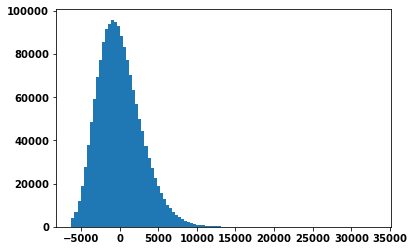

interactive(children=(Dropdown(description='Color', index=1, options=('prism', 'cividis', 'Gators', 'Reds', 'i…

In [139]:
t = 4500
sm = ndi.gaussian_filter(im, 3)
mask = np.where(sm > t, True, False)
nucmean = np.mean(im[mask])
diff = im - nucmean
resid_vals = diff[mask]
vals = im[mask]
plt.hist(resid_vals, bins=100);
fm.viewer(mask)

In [140]:
max_ = 15_000
mixture_onegauss = mixmod.MixtureModel([stats.norm], params=[{'loc': 5000, 'scale': 3000}])
mixture_gamma_gauss = mixmod.MixtureModel([stats.gamma, stats.norm], params=[{'a':1, 'scale':10_000},{'scale':10_000}])
vals = vals
mixture_onegauss.fit(data=vals)
mixture_gamma_gauss.fit(data=vals)


(157, -15576536.678086651)

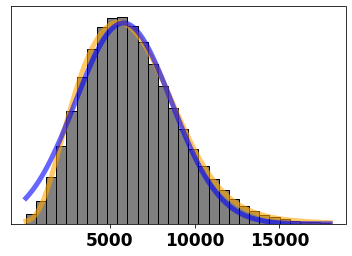

In [153]:
bins=100
max_ = 18_000
plt.hist(vals, bins=30, density=True, facecolor='grey', edgecolor='black', range=(vals.min(), max_));
x = np.linspace(vals.min(), max_, bins)
y = mixture_onegauss.pdf(x)
#plt.plot(x,y, linewidth=5, alpha=0.5, color="blue")
x = np.linspace(vals.min(), max_, bins)
y = mixture_gamma_gauss.pdf(x)
plt.plot(x,y, linewidth=5, alpha=0.6, color="orange")
y = stats.norm.pdf(x, loc=5800, scale=2836)
plt.plot(x,y, linewidth=5, alpha=0.6, color="blue")
plt.yticks([])
plt.xticks([5000, 10000, 15000], size=17)
#plt.xlabel('Pixel Intensity', size=17)
plt.savefig('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/figuredata/W2-describe-sim-msm/noise_hist.png', dpi=300)

### Panels of nuclei

This is a slightly complicated jaunt because downloading the full library of sims is a lot of space.

1. Save a list of filenames that fit the cutoff using *__match_names_and_distcutoff()__*  

2. Download files from server using rsync. Example: 

       rsync -a --files-from=FILENAMES.txt mstadler@dtn.brc.berkeley.edu:/global/home/users/mstadler/scratch/ .

3. Make image panels using *__display_real_sim_pattern_cutoff()__*

In [63]:
# Make temp folder and stock
real_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl'
#sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-rpb1-nc13-library_sJQraOLX__20220619-plussims-20220616-realreal.pkl'
sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220815-zld-nc13-100nm-reallib_EXbVKYNG__20220619-plussims-20220616-realreal.pkl'

savefile = '/Users/michaelstadler/Desktop/test.png'
#pattern = 'rpb1.*nc13-3_|rpb1.*nc13-4_|rpb1.*nc13-5_|rpb1.*nc13-6_'
pattern = 'zld-wt.*nc13-3_|zld-wt.*nc13-4_|zld-wt.*nc13-5_|zld-wt.*nc13-6_'
dir_reals = '/Volumes/stadler_5tb/real-nuclei-set3-matched-20220630'
dir_sims = '/Volumes/stadler_5tb/matched_sim_images/20220815-zld-nc13-100nm-reallib_EXbVKYNG'

In [42]:
# If needed, save filename and extract using rsync.
cutoff_lower_tosave = 0
cutoff_upper_tosave = 0.6
savestem = '/Volumes/stadler_5tb/matched_sim_images/file_lists/20220815-zld-nc13-100nm-reallib_EXbVKYNG__20220619-plussims-20220616-realreal_0_06'

_ = fm.figures.match_names_and_distcutoff(real_embedding_pkl, sims_embedding_pkl, cutoff_lower_tosave, cutoff_upper_tosave, savestem, pattern)

(10, 34, 100, 100)
(10, 34, 100, 100)


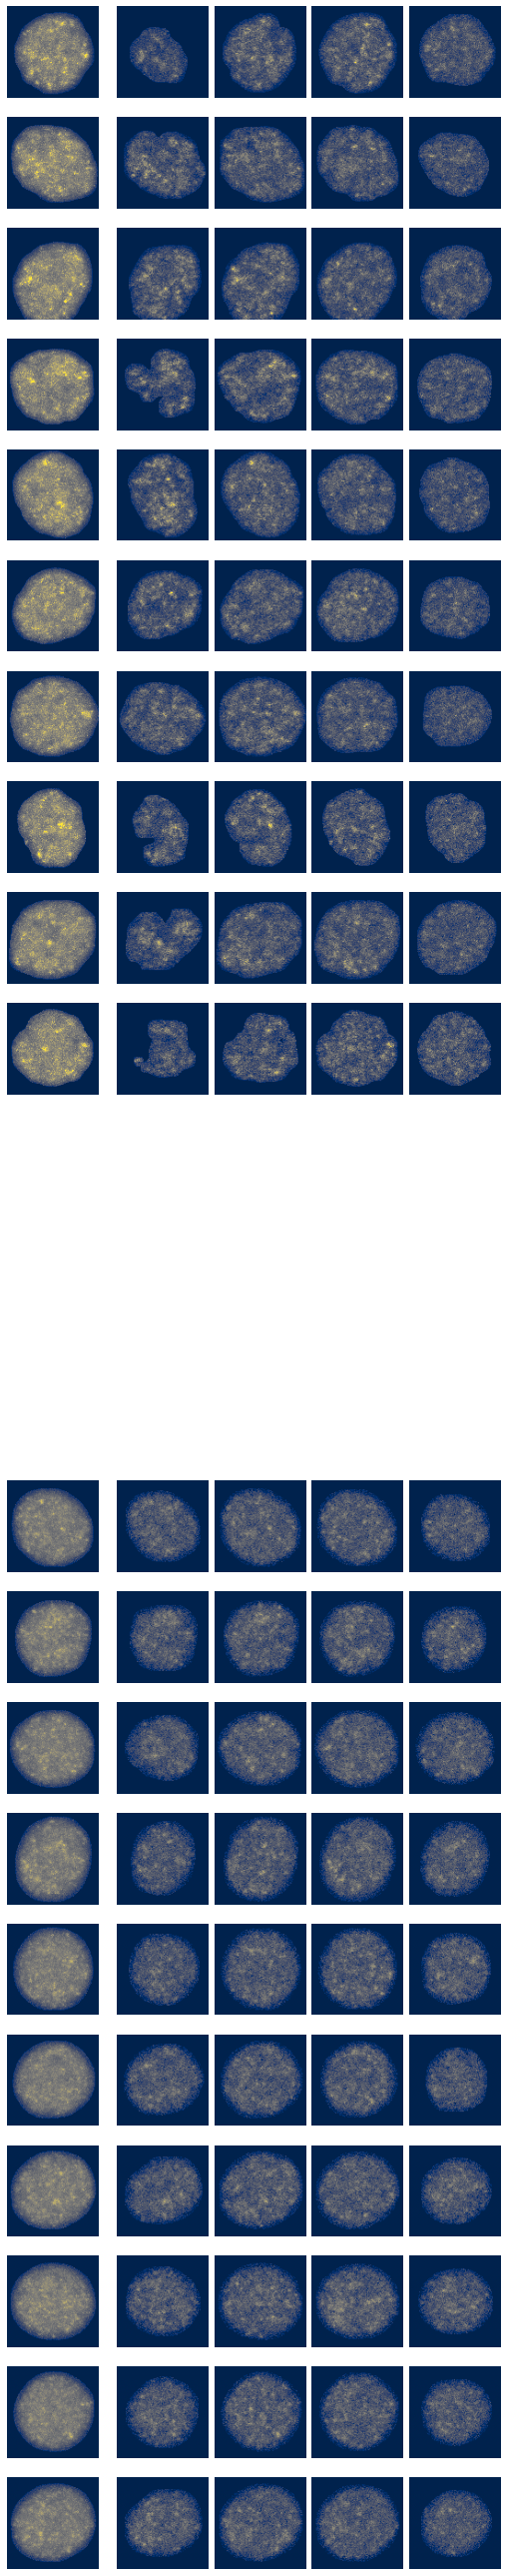

In [96]:
savefile = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/temp/narrow.png'
pattern = 'zld-wt.*nc13-5_'
fm.figures.display_real_sim_pattern_cutoff(real_embedding_pkl, sims_embedding_pkl, dir_reals, dir_sims, pattern, 0, 0.3, savefile, [10, 10])

In [61]:
# Quickshot: writing a file with files that have not yet been downloaded.
filelist = pd.read_csv('/Volumes/stadler_5tb/matched_sim_images/file_lists/20220815-zld-nc13-100nm-reallib_EXbVKYNG__20220619-plussims-20220616-realreal_0_06_sims.txt').iloc[:,0]

donelist = os.listdir('/Volumes/stadler_5tb/matched_sim_images/20220815-zld-nc13-100nm-reallib_EXbVKYNG')
doneset = set(donelist)

with open('/Volumes/stadler_5tb/matched_sim_images/file_lists/temp1.txt', 'w') as outfile:
    for f in filelist:
        if f[0] == '.':
            continue
        if f not in doneset:
            outfile.write(f + '\n')
